In [ ]:
!pip install keras
!pip install scikit-learn

Importar biblioteca

In [ ]:
# Importando as bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

Carregar e Preparar o Dataset

In [ ]:
data = pd.read_csv('/home/Electric_Production.csv')
data

,DATE,IPG2211A2N
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151
...,...,...
392,9/1/2017,98.6154
393,10/1/2017,93.6137
394,11/1/2017,97.3359
395,12/1/2017,114.7212


In [ ]:
# Conferindo o tipo das colunas
data.dtypes

,0
DATE,object
IPG2211A2N,float64


Realizando a normalizacao do dataset

In [ ]:
# Converter a coluna Date para o tipo datetime
data['DATE'] = pd.to_datetime(data['DATE'])

# Normalizar os dados para que fiquem entre 0 e 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['IPG2211A2N'].values.reshape(-1, 1))

# Mostrar as primeiras linhas dos dados
data.head()


,DATE,IPG2211A2N
0,1985-01-01,72.5052
1,1985-02-01,70.6720
2,1985-03-01,62.4502
3,1985-04-01,57.4714
4,1985-05-01,55.3151


In [ ]:
# Descobrindo nossa Data inicial e Data final para podermos definir o look-back
data['DATE'].min(), data['DATE'].max()

(Timestamp('1985-01-01 00:00:00'), Timestamp('2018-01-01 00:00:00'))

Criando a funcao

In [ ]:
# Definir o tamanho da janela (look-back)
look_back = 15  # Usar os últimos 15 dias para previsão

# Criar sequências de dados para a RNN
def create_dataset(data, look_back=1):
    # Inicializa listas vazias para armazenar os dados de entrada (X) e saída (y)
    X, y = [], []

    # Itera sobre o conjunto de dados, parando antes do comprimento total menos o look_back
    for i in range(len(data) - look_back):
        # Adiciona uma janela de dados de entrada à lista X
        # O slice data[i:(i + look_back), 0] pega os dados desde o índice i até i + look_back; o valor 0 indica a coluna
        X.append(data[i:(i + look_back), 0])  # Dados de entrada

        # Adiciona o próximo valor (o que segue a janela de entrada) à lista y
        # O índice i + look_back se refere ao valor que queremos prever
        y.append(data[i + look_back, 0])      # Dados de saída

    # Converte as listas X e y em arrays NumPy e retorna
    return np.array(X), np.array(y)


In [ ]:
# Criar os conjuntos de dados
X, y = create_dataset(scaled_data, look_back)

# Redimensionar os dados para [amostras, passos do tempo, características]
X = X.reshape(X.shape[0], X.shape[1], 1)

# Dividir em conjunto de treinamento e teste (80% para treinamento, 20% para teste)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Mostrar a forma dos conjuntos de dados
#(número de linhas,número de passos de tempo ou o look-back, número de colunas)
print(f'Treinamento: {X_train.shape}, Teste: {X_test.shape}')


Treinamento: (305, 15, 1), Teste: (77, 15, 1)


Construir a Rede Neural Recorrente (RNN)

In [ ]:
# Criar o modelo LSTM
model = Sequential()
model.add(LSTM(150, return_sequences=True, input_shape=(X_train.shape[1], 1)))  # Primeira camada LSTM
model.add(Dropout(0.2))  # Camada Dropout para evitar overfitting
model.add(LSTM(100, return_sequences=True))  # Segunda camada LSTM
model.add(Dropout(0.2))  # Camada Dropout
model.add(LSTM(50, return_sequences=False))  # Quarta camada LSTM (última camada LSTM)
model.add(Dense(1))  # Camada de saída para previsão do preço

# Compilar o modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Mostrar a arquitetura do modelo
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 15, 150)             │          91,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 15, 150)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 15, 100)             │         100,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 15, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 50)                  │          30,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 221,851 (866.61 KB)

 Trainable params: 221,851 (866.61 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Treinar o modelo
model.fit(X_train, y_train, epochs=100, batch_size=32)

# Salvar o modelo se desejar
# model.save('modelo_acoes.h5')

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 0.1506
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0181
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0153
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0146
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0119
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0114
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0106
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0115
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0126
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0120
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0113
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0124
Epoch 13/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0118
Epoch 14/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0112
Epoch 15/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - lo

Fazendo as previsoes de dados do modelo e normalizando quando necessario

In [ ]:
# Prever o próximo valor
last_data = scaled_data[-look_back:].reshape(1, look_back, 1)  # Últimos 90 dias para previsão
predicted_eletric = model.predict(last_data)  # Fazer a previsão

# Inverter a normalização para obter o preço real
predicted_eletric = scaler.inverse_transform(predicted_eletric)
print(f'Preço para proxima produção: {predicted_eletric[0][0]:.2f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step
Preço para proxima produção: 107.13


In [ ]:
# Fazer previsões no conjunto de teste
predictions = model.predict(X_test)

# Inverter a normalização das previsões
predictions = scaler.inverse_transform(predictions)

# Caso as variáveis estejam com tamanhos incompatíveis, corte y_test para o tamanho de predictions
y_test_trimmed = y_test[:predictions.shape[0]]

# Inverter a normalização de predictions
predictions_inverted = scaler.inverse_transform(predictions.reshape(-1, 1))

# Inverter a normalização de y_test_trimmed
y_test_trimmed_inverted = scaler.inverse_transform(y_test_trimmed.reshape(-1, 1))

# Calcular RMSE
rmse = np.sqrt(np.mean(np.square(predictions - scaler.inverse_transform(y_test.reshape(-1, 1)))))
print(f'Root Mean Squared Error: {rmse:.2f}')

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step 
Root Mean Squared Error: 5.19


In [ ]:
# Prever as três próximas amostras
predicted_eletrics = []

# Usar os últimos 7 dias para começar
last_data = scaled_data[-look_back:].reshape(1, look_back, 1)

for _ in range(7):  # Prever 7 dias
    predicted_eletric = model.predict(last_data)  # Fazer a previsão
    predicted_eletrics.append(predicted_eletric[0][0])  # Armazenar a previsão

    # Atualizar last_data para incluir a nova previsão
    last_data = np.append(last_data[:, 1:, :], predicted_eletric.reshape(1, 1, 1), axis=1)

# Inverter a normalização para obter os preços reais
predicted_eletrics = scaler.inverse_transform(np.array(predicted_eletrics).reshape(-1, 1))

# Mostrar os preços previstos para os próximos 3 dias
for i, producao in enumerate(predicted_eletrics, start=1):
    print(f'Produção previsto para o dia {i}: {producao[0]:.2f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Produção previsto para o dia 1: 107.13
Produção previsto para o dia 2: 96.14
Produção previsto para o dia 3: 90.71
Produção previsto para o dia 4: 93.99
Produção previsto para o dia 5: 101.57
Produção previsto para o dia 6: 113.75
Produção previsto para o dia 7: 111.66


Plotando o grafico com os dados previstos

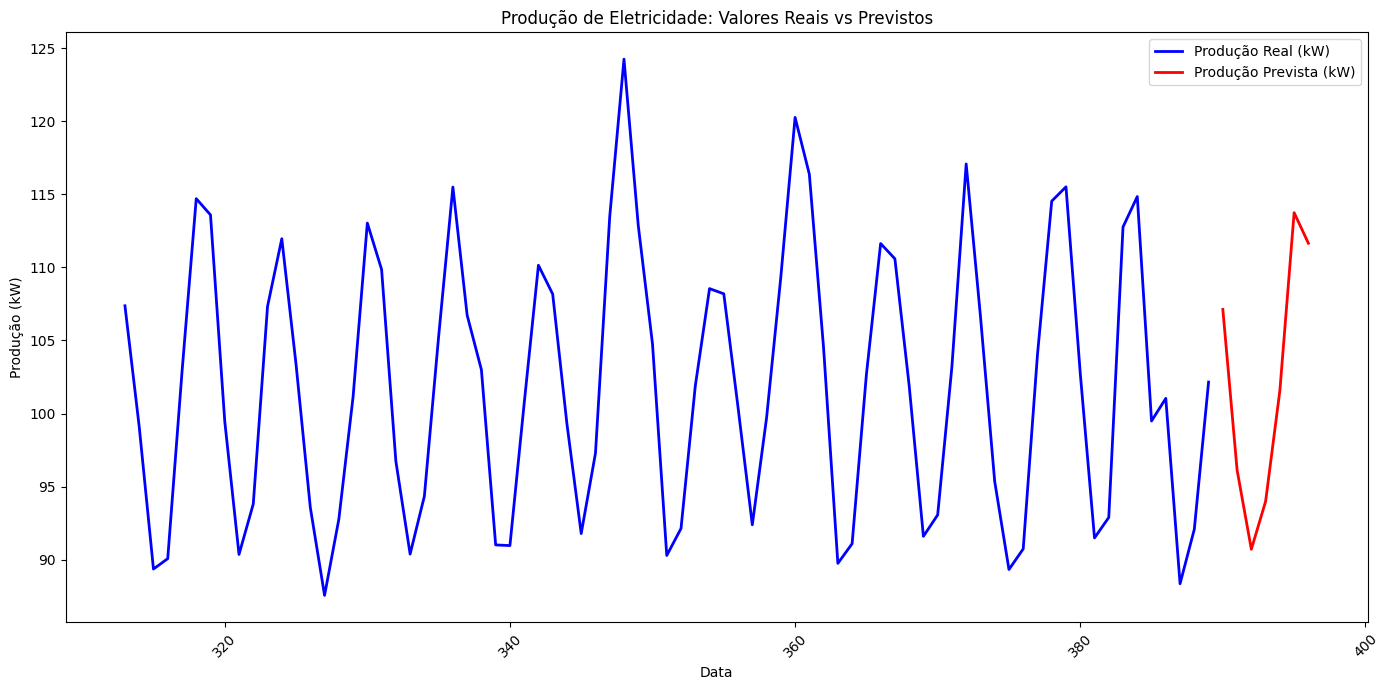

In [ ]:
# Criar um DataFrame com os dados reais
real_producao = data['IPG2211A2N'].values[-(len(y_test) + 7):]  # Inclui os últimos valores reais + 7 previsões

# Concatenar as previsões com os preços previstos para os próximos 14 dias
predicted_producao_full = np.concatenate([predictions.flatten(), predicted_eletrics.flatten()])

# Criar o índice para os dias
dates = data.index[-(len(y_test) + 7):]  # Últimos índices

# Plotar
plt.figure(figsize=(14, 7))
plt.plot(dates[:len(y_test)], real_producao[:len(y_test)], color='blue', label='Produção Real (kW)', linewidth=2)
plt.plot(dates[len(y_test):], predicted_producao_full[len(y_test):], color='red', label='Produção Prevista (kW)', linewidth=2)
plt.title('Produção de Eletricidade: Valores Reais vs Previstos')
plt.xlabel('Data')
plt.ylabel('Produção (kW)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Comparando o grafico com os Dados Reais x Previstos

Média das previsões: 102.13 kW
Média real: 102.42 kW


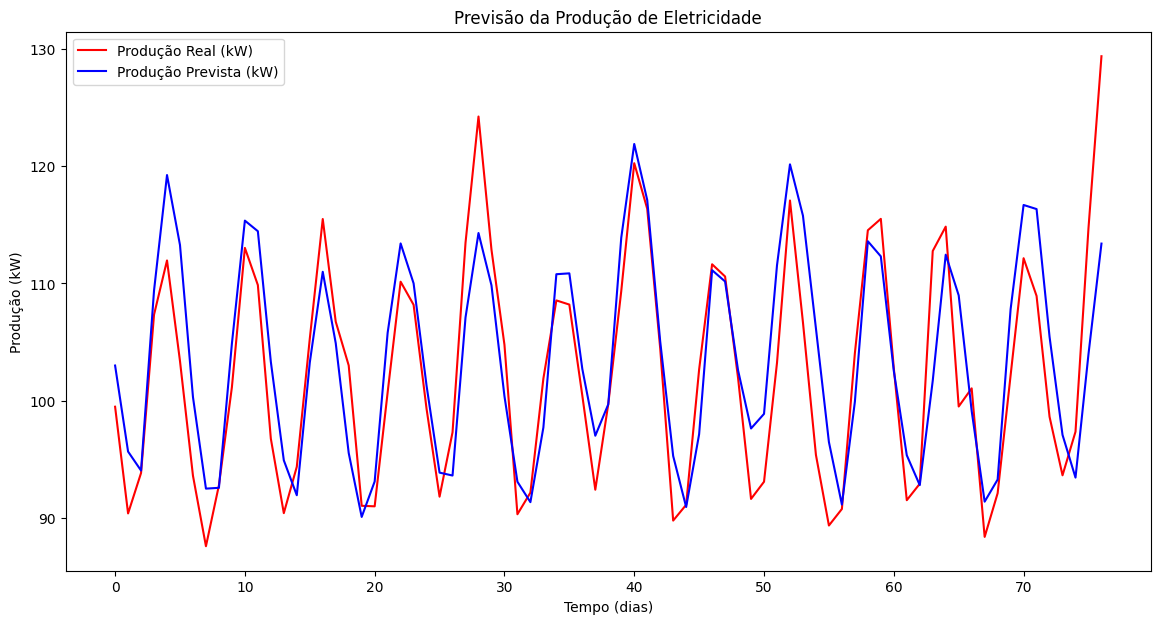

In [ ]:
# Calcular médias
media_previsoes = predicted_eletrics.flatten().mean()
media_real = scaler.inverse_transform(y_test.reshape(-1, 1)).mean()

print(f"Média das previsões: {media_previsoes:.2f} kW")
print(f"Média real: {media_real:.2f} kW")

# Plotar gráfico
plt.figure(figsize=(14, 7))
plt.plot(scaler.inverse_transform(y_test.reshape(-1, 1)), color='red', label='Produção Real (kW)')  # Produção real
plt.plot(predictions, color='blue', label='Produção Prevista (kW)')  # Previsões do conjunto de teste
plt.title('Previsão da Produção de Eletricidade')
plt.xlabel('Tempo (dias)')
plt.ylabel('Produção (kW)')
plt.legend()
plt.show()